In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.layers import Dense, Dropout, concatenate

from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
dataset = pd.read_csv('../data/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


In [4]:
print(dataset.columns)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
# specify the number of lag hours
n_hours = 24*3
K = 24
S = 24

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [6]:
# Pre-processing
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96337, 384)


In [7]:
stages_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),var1(t-70),var2(t-70),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.93,1.97,2.03,1.990,1.48,1.48,1.59,1.54,0.98,0.97,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
12/30/20 21:00,1.48,1.48,1.59,1.540,0.98,0.97,1.05,1.01,0.58,0.61,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
12/30/20 22:00,0.98,0.97,1.05,1.010,0.58,0.61,0.72,0.66,0.04,0.03,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04


#### Prior unknown covariates (6)

In [8]:
prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
print("prior_unknown.shape:", prior_unknown.shape)

prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, S)
print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

prior_unknown.shape: (96432, 6)
prior_unknown_supervised.shape: (96337, 576)


In [9]:
prior_unknown_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),...,var3(t+22),var4(t+22),var5(t+22),var6(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var5(t+23),var6(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.88,0.00,2.72,0.0,2.10,0.0,2.89,0.00,2.73
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.89,0.00,2.73,0.0,2.12,0.0,2.87,0.00,2.74
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,0.0,2.15,0.00,2.83,...,0.0,2.87,0.00,2.74,0.0,2.14,0.0,2.89,0.00,2.74
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,0.0,2.13,0.00,2.84,...,0.0,2.89,0.00,2.74,0.0,2.15,0.0,2.87,0.00,2.74
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,0.0,2.12,0.00,2.84,...,0.0,2.87,0.00,2.74,0.0,2.15,0.0,2.89,0.00,2.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,0.0,1.92,240.09,2.52,302.67,2.55,0.0,1.93,325.17,2.51,...,0.0,2.83,534.14,2.47,0.0,1.92,0.0,2.86,456.34,2.49
12/30/20 21:00,0.0,1.93,325.17,2.51,393.59,2.48,0.0,1.94,406.56,2.48,...,0.0,2.86,456.34,2.49,0.0,1.92,0.0,2.88,380.19,2.48
12/30/20 22:00,0.0,1.94,406.56,2.48,475.32,2.40,0.0,1.94,445.67,2.43,...,0.0,2.88,380.19,2.48,0.0,1.93,0.0,2.89,287.12,2.54


#### Prior known covariates (9)

In [10]:
prior_known = dataset[['WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', 'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, S)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (96432, 9)
prior_known_supervised.shape: (96337, 864)


In [11]:
prior_known_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var1(t-71),...,var9(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var5(t+23),var6(t+23),var7(t+23),var8(t+23),var9(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.34,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.28,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 01:00,-0.28,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.73,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 02:00,-0.73,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.85,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 03:00,-0.85,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.49,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 04:00,-0.49,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.21,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.79,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,1.31,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
12/30/20 21:00,1.31,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,0.86,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
12/30/20 22:00,0.86,0.0,0.0,2.58,0.0,0.0,2.57,0.0,0.000000,0.42,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


### N_out, N_in, K

#### all past covariates in past $w$ hours

In [12]:
# 15 covariates in total
cov = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26',\
                   'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', \
                    'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]

cov_supervised = series_to_supervised(cov, n_hours, S)
print("cov_supervised.shape:", cov_supervised.shape)

cov_supervised.shape: (96337, 1440)


In [13]:
past_cov_supervised = cov_supervised.iloc[:, :n_hours*cov.shape[1]]

In [14]:
past_cov_supervised  # 6 + 9 = 15 features

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.76,2.13,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.78,2.03,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.77,1.47,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.77,0.83,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.77,0.31,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,2.57,1.57,0.0,0.0,2.56,0.0,0.0,2.57,0.0,0.0
12/30/20 21:00,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.55,1.94,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0
12/30/20 22:00,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.56,2.08,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0


#### all target water stages in past $w$ hours

In [15]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [16]:
past_ws_supervised  # 4

,past_ws_supervised_var1(t-72),past_ws_supervised_var2(t-72),past_ws_supervised_var3(t-72),past_ws_supervised_var4(t-72),past_ws_supervised_var1(t-71),past_ws_supervised_var2(t-71),past_ws_supervised_var3(t-71),past_ws_supervised_var4(t-71),past_ws_supervised_var1(t-70),past_ws_supervised_var2(t-70),...,past_ws_supervised_var3(t-3),past_ws_supervised_var4(t-3),past_ws_supervised_var1(t-2),past_ws_supervised_var2(t-2),past_ws_supervised_var3(t-2),past_ws_supervised_var4(t-2),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.38,1.34,1.79,1.92,1.94,1.91,2.11,2.29,2.27,2.21
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.94,1.91,2.11,2.29,2.27,2.21,2.07,2.27,2.26,2.22
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.27,2.21,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.93,1.97,2.03,1.990,1.48,1.48,1.59,1.54,0.98,0.97,...,0.60,0.54,1.14,1.18,1.17,1.25,1.62,1.65,1.70,1.67
12/30/20 21:00,1.48,1.48,1.59,1.540,0.98,0.97,1.05,1.01,0.58,0.61,...,1.17,1.25,1.62,1.65,1.70,1.67,1.93,1.95,2.00,2.00
12/30/20 22:00,0.98,0.97,1.05,1.010,0.58,0.61,0.72,0.66,0.04,0.03,...,1.70,1.67,1.93,1.95,2.00,2.00,2.19,2.21,2.25,2.25


#### merge all data (ws, covariates) in past $w$ hours

In [17]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*cov.shape[1]:(i+1)*cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [18]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :], 
                                    past_ws_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :]], 
                                   axis=1)

past_cov_ws_supervised = past_cov_ws_supervised[columns]

In [19]:
past_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,2.11,2.29,2.27,2.21
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,2.07,2.27,2.26,2.22
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,1.57,1.80,1.80,1.72
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.81,1.04,1.03,0.96
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,2.56,0.0,0.0,2.57,0.0,0.0,1.62,1.65,1.70,1.67
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.57,0.0,0.0,2.57,0.0,0.0,1.93,1.95,2.00,2.00
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.57,0.0,0.0,2.57,0.0,0.0,2.19,2.21,2.25,2.25
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,2.57,0.0,0.0,2.57,0.0,0.0,2.11,2.12,2.22,2.19


#### shift prior known covariates in future  $S$ steps to the past

In [20]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, S*prior_known.shape[1]:]
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-48),shift_prior_known_supervised_var2(t-48),shift_prior_known_supervised_var3(t-48),shift_prior_known_supervised_var4(t-48),shift_prior_known_supervised_var5(t-48),shift_prior_known_supervised_var6(t-48),shift_prior_known_supervised_var7(t-48),shift_prior_known_supervised_var8(t-48),shift_prior_known_supervised_var9(t-48),shift_prior_known_supervised_var1(t-47),...,shift_prior_known_supervised_var9(t+22),shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23)
0,0.60,0.0,0.0,0.00,0.0,0.0,2.61,0.0,0.0,-0.07,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,-0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.68,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,-0.68,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-1.02,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,-1.02,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.97,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,-0.97,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.50,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.91,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.67,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,1.67,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.16,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,1.16,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,0.68,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.68,0.0,0.0,2.57,0.0,0.0,2.56,0.0,0.0,0.24,...,0.0,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### merge all past data and shifted prior know future covariate

In [21]:
columns1 = []
for i in range(n_hours):
    columns1 = columns1 + past_cov_ws_supervised.columns[i*data.shape[1]:(i+1)*data.shape[1]].tolist()
    columns1 = columns1 + shift_prior_known_supervised.columns[i*prior_known.shape[1]:(i+1)*prior_known.shape[1]].tolist()
# columns

In [22]:
shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :], 
                                                 shift_prior_known_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :]],
                                                axis=1)

shift_prior_known_cov_ws_supervised = shift_prior_known_cov_ws_supervised[columns1]

In [23]:
# shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], 
#                                                      axis=1)

In [24]:
shift_prior_known_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,past_ws_supervised_var4(t-1),shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.21,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.22,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,1.72,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.96,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.42,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,1.67,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.00,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.25,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,2.19,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### target water stage in future $k$ time steps

In [25]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var2(t),var3(t),var4(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var1(t+2),var2(t+2),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
0,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
2,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42,-0.29,-0.02,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
3,0.27,0.53,0.50,0.42,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
4,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,-0.49,-0.57,-0.64,-0.46,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.93,1.95,2.00,2.00,2.19,2.21,2.25,2.25,2.11,2.12,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96333,2.19,2.21,2.25,2.25,2.11,2.12,2.22,2.19,1.65,1.69,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96334,2.11,2.12,2.22,2.19,1.65,1.69,1.76,1.72,1.24,1.24,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96335,1.65,1.69,1.76,1.72,1.24,1.24,1.37,1.32,0.76,0.73,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Concatenation

In [26]:
all_data = concat([shift_prior_known_cov_ws_supervised, 
                   future_ws_supervised.iloc[:shift_prior_known_cov_ws_supervised.shape[0], :]], 
                  axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96337, 2112)


In [27]:
all_data

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Train & Test set

In [28]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 77069


In [29]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

2016

### Normalization

In [30]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (77069, 2016) (77069, 96) (19268, 2016) (19268, 96)


In [31]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (77069, 72, 28) (77069, 96) (19268, 72, 28) (19268, 96)


### Model

In [33]:
model_input = Input(shape=(train_X.shape[1], train_X.shape[2]))

# 3 cnn with skip connection
x1 = layers.Conv1D(filters=256, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)


# 3 rnn with skip connection
x2 = layers.SimpleRNN(128, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)


merge = concatenate([model_input, x1, x2])
merge = layers.Flatten()(merge)
# x = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(merge)
# x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
# x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
# x = Dense(64, activation='relu')(x)
x = Dense(train_y.shape[1])(merge)


ws_pararcnn = Model(model_input, x)
ws_pararcnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 72, 28)]     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 72, 256)      14592       input_2[0][0]                    
__________________________________________________________________________________________________
simple_rnn_1 (SimpleRNN)        (None, 72, 128)      20096       input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 72, 412)      0           input_2[0][0]                    
                                                                 conv1d_1[0][0]             

Epoch 1/8000


2023-01-05 23:28:56.588474: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-01-05 23:28:57.152646: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-01-05 23:29:01.165609: E tensorflow/stream_executor/gpu/asm_compiler.cc:110] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 9.2.88).  Compilation of XLA kernels below will likely fail.

You do not need to update CUDA; cherry-picking the ptxas binary is sufficient.
2023-01-05 23:29:01.714980: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 65280, output: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.



Epoch 00001: val_mae improved from inf to 0.04347, saving model to saved_model/ws_pararcnn_sc1_1layer_24h.h5
151/151 - 17s - loss: 0.0351 - mae: 0.0653 - val_loss: 0.0215 - val_mae: 0.0435
Epoch 2/8000

Epoch 00002: val_mae improved from 0.04347 to 0.03155, saving model to saved_model/ws_pararcnn_sc1_1layer_24h.h5
151/151 - 6s - loss: 0.0172 - mae: 0.0216 - val_loss: 0.0162 - val_mae: 0.0316
Epoch 3/8000

Epoch 00003: val_mae improved from 0.03155 to 0.02739, saving model to saved_model/ws_pararcnn_sc1_1layer_24h.h5
151/151 - 6s - loss: 0.0138 - mae: 0.0164 - val_loss: 0.0133 - val_mae: 0.0274
Epoch 4/8000

Epoch 00004: val_mae improved from 0.02739 to 0.02505, saving model to saved_model/ws_pararcnn_sc1_1layer_24h.h5
151/151 - 6s - loss: 0.0116 - mae: 0.0142 - val_loss: 0.0114 - val_mae: 0.0251
Epoch 5/8000

Epoch 00005: val_mae improved from 0.02505 to 0.02468, saving model to saved_model/ws_pararcnn_sc1_1layer_24h.h5
151/151 - 6s - loss: 0.0100 - mae: 0.0129 - val_loss: 0.0100 - va

Epoch 49/8000

Epoch 00049: val_mae did not improve from 0.01513
151/151 - 6s - loss: 2.1614e-04 - mae: 0.0081 - val_loss: 5.0274e-04 - val_mae: 0.0157
Epoch 50/8000

Epoch 00050: val_mae did not improve from 0.01513
151/151 - 6s - loss: 2.1307e-04 - mae: 0.0081 - val_loss: 5.0599e-04 - val_mae: 0.0160
Epoch 51/8000

Epoch 00051: val_mae did not improve from 0.01513
151/151 - 5s - loss: 2.1025e-04 - mae: 0.0081 - val_loss: 5.5023e-04 - val_mae: 0.0167
Epoch 52/8000

Epoch 00052: val_mae improved from 0.01513 to 0.01485, saving model to saved_model/ws_pararcnn_sc1_1layer_24h.h5
151/151 - 6s - loss: 2.0505e-04 - mae: 0.0080 - val_loss: 4.4000e-04 - val_mae: 0.0148
Epoch 53/8000

Epoch 00053: val_mae did not improve from 0.01485
151/151 - 5s - loss: 2.0849e-04 - mae: 0.0082 - val_loss: 6.1972e-04 - val_mae: 0.0180
Epoch 54/8000

Epoch 00054: val_mae did not improve from 0.01485
151/151 - 5s - loss: 2.0664e-04 - mae: 0.0082 - val_loss: 5.1949e-04 - val_mae: 0.0161
Epoch 55/8000

Epoch 0005

Epoch 102/8000

Epoch 00102: val_mae did not improve from 0.01335
151/151 - 5s - loss: 1.7537e-04 - mae: 0.0076 - val_loss: 4.6076e-04 - val_mae: 0.0154
Epoch 103/8000

Epoch 00103: val_mae did not improve from 0.01335
151/151 - 5s - loss: 1.7451e-04 - mae: 0.0075 - val_loss: 4.4398e-04 - val_mae: 0.0147
Epoch 104/8000

Epoch 00104: val_mae did not improve from 0.01335
151/151 - 5s - loss: 1.7360e-04 - mae: 0.0075 - val_loss: 4.4078e-04 - val_mae: 0.0149
Epoch 105/8000

Epoch 00105: val_mae did not improve from 0.01335
151/151 - 5s - loss: 1.7208e-04 - mae: 0.0074 - val_loss: 4.2809e-04 - val_mae: 0.0147
Epoch 106/8000

Epoch 00106: val_mae did not improve from 0.01335
151/151 - 5s - loss: 1.7486e-04 - mae: 0.0076 - val_loss: 4.0523e-04 - val_mae: 0.0144
Epoch 107/8000

Epoch 00107: val_mae did not improve from 0.01335
151/151 - 5s - loss: 1.7557e-04 - mae: 0.0076 - val_loss: 4.6287e-04 - val_mae: 0.0153
Epoch 108/8000

Epoch 00108: val_mae did not improve from 0.01335
151/151 - 5s - l

Epoch 156/8000

Epoch 00156: val_mae did not improve from 0.01271
151/151 - 6s - loss: 1.6365e-04 - mae: 0.0073 - val_loss: 3.9498e-04 - val_mae: 0.0140
Epoch 157/8000

Epoch 00157: val_mae did not improve from 0.01271
151/151 - 6s - loss: 1.6550e-04 - mae: 0.0074 - val_loss: 4.5976e-04 - val_mae: 0.0152
Epoch 158/8000

Epoch 00158: val_mae did not improve from 0.01271
151/151 - 6s - loss: 1.6037e-04 - mae: 0.0072 - val_loss: 3.7779e-04 - val_mae: 0.0137
Epoch 159/8000

Epoch 00159: val_mae did not improve from 0.01271
151/151 - 6s - loss: 1.6487e-04 - mae: 0.0074 - val_loss: 3.7215e-04 - val_mae: 0.0137
Epoch 160/8000

Epoch 00160: val_mae did not improve from 0.01271
151/151 - 6s - loss: 1.6045e-04 - mae: 0.0072 - val_loss: 3.9713e-04 - val_mae: 0.0141
Epoch 161/8000

Epoch 00161: val_mae did not improve from 0.01271
151/151 - 6s - loss: 1.6418e-04 - mae: 0.0073 - val_loss: 4.0062e-04 - val_mae: 0.0141
Epoch 162/8000

Epoch 00162: val_mae did not improve from 0.01271
151/151 - 6s - l

Epoch 210/8000

Epoch 00210: val_mae did not improve from 0.01205
151/151 - 6s - loss: 1.6262e-04 - mae: 0.0074 - val_loss: 4.2216e-04 - val_mae: 0.0144
Epoch 211/8000

Epoch 00211: val_mae did not improve from 0.01205
151/151 - 6s - loss: 1.5808e-04 - mae: 0.0072 - val_loss: 4.0487e-04 - val_mae: 0.0140
Epoch 212/8000

Epoch 00212: val_mae did not improve from 0.01205
151/151 - 6s - loss: 1.5586e-04 - mae: 0.0071 - val_loss: 3.5745e-04 - val_mae: 0.0134
Epoch 213/8000

Epoch 00213: val_mae did not improve from 0.01205
151/151 - 6s - loss: 1.5673e-04 - mae: 0.0071 - val_loss: 4.2063e-04 - val_mae: 0.0149
Epoch 214/8000

Epoch 00214: val_mae did not improve from 0.01205
151/151 - 6s - loss: 1.5680e-04 - mae: 0.0071 - val_loss: 3.8610e-04 - val_mae: 0.0137
Epoch 215/8000

Epoch 00215: val_mae did not improve from 0.01205
151/151 - 6s - loss: 1.5426e-04 - mae: 0.0070 - val_loss: 4.3762e-04 - val_mae: 0.0150
Epoch 216/8000

Epoch 00216: val_mae did not improve from 0.01205
151/151 - 6s - l

Epoch 264/8000

Epoch 00264: val_mae did not improve from 0.01199
151/151 - 6s - loss: 1.5556e-04 - mae: 0.0072 - val_loss: 3.4181e-04 - val_mae: 0.0132
Epoch 265/8000

Epoch 00265: val_mae did not improve from 0.01199
151/151 - 6s - loss: 1.5316e-04 - mae: 0.0071 - val_loss: 3.3949e-04 - val_mae: 0.0130
Epoch 266/8000

Epoch 00266: val_mae did not improve from 0.01199
151/151 - 6s - loss: 1.5238e-04 - mae: 0.0070 - val_loss: 3.3269e-04 - val_mae: 0.0126
Epoch 267/8000

Epoch 00267: val_mae did not improve from 0.01199
151/151 - 6s - loss: 1.5379e-04 - mae: 0.0071 - val_loss: 3.7878e-04 - val_mae: 0.0137
Epoch 268/8000

Epoch 00268: val_mae did not improve from 0.01199
151/151 - 6s - loss: 1.5270e-04 - mae: 0.0071 - val_loss: 3.0918e-04 - val_mae: 0.0124
Epoch 269/8000

Epoch 00269: val_mae did not improve from 0.01199
151/151 - 6s - loss: 1.5205e-04 - mae: 0.0070 - val_loss: 3.7024e-04 - val_mae: 0.0135
Epoch 270/8000

Epoch 00270: val_mae did not improve from 0.01199
151/151 - 6s - l

Epoch 318/8000

Epoch 00318: val_mae did not improve from 0.01165
151/151 - 6s - loss: 1.4800e-04 - mae: 0.0069 - val_loss: 3.4367e-04 - val_mae: 0.0126
Epoch 319/8000

Epoch 00319: val_mae did not improve from 0.01165
151/151 - 6s - loss: 1.5258e-04 - mae: 0.0071 - val_loss: 3.5848e-04 - val_mae: 0.0134
Epoch 320/8000

Epoch 00320: val_mae did not improve from 0.01165
151/151 - 6s - loss: 1.5252e-04 - mae: 0.0071 - val_loss: 3.4644e-04 - val_mae: 0.0131
Epoch 321/8000

Epoch 00321: val_mae did not improve from 0.01165
151/151 - 6s - loss: 1.4751e-04 - mae: 0.0069 - val_loss: 3.4094e-04 - val_mae: 0.0127
Epoch 322/8000

Epoch 00322: val_mae did not improve from 0.01165
151/151 - 6s - loss: 1.5021e-04 - mae: 0.0070 - val_loss: 3.7567e-04 - val_mae: 0.0137
Epoch 323/8000

Epoch 00323: val_mae did not improve from 0.01165
151/151 - 6s - loss: 1.4644e-04 - mae: 0.0068 - val_loss: 2.9103e-04 - val_mae: 0.0120
Epoch 324/8000

Epoch 00324: val_mae did not improve from 0.01165
151/151 - 6s - l

Epoch 372/8000

Epoch 00372: val_mae did not improve from 0.01165
151/151 - 6s - loss: 1.4830e-04 - mae: 0.0070 - val_loss: 3.3937e-04 - val_mae: 0.0130
Epoch 373/8000

Epoch 00373: val_mae did not improve from 0.01165
151/151 - 6s - loss: 1.4721e-04 - mae: 0.0069 - val_loss: 3.8104e-04 - val_mae: 0.0133
Epoch 374/8000

Epoch 00374: val_mae did not improve from 0.01165
151/151 - 6s - loss: 1.4400e-04 - mae: 0.0068 - val_loss: 3.8648e-04 - val_mae: 0.0139
Epoch 375/8000

Epoch 00375: val_mae did not improve from 0.01165
151/151 - 6s - loss: 1.4859e-04 - mae: 0.0070 - val_loss: 3.0612e-04 - val_mae: 0.0123
Epoch 376/8000

Epoch 00376: val_mae did not improve from 0.01165
151/151 - 6s - loss: 1.4652e-04 - mae: 0.0069 - val_loss: 2.7887e-04 - val_mae: 0.0118
Epoch 377/8000

Epoch 00377: val_mae did not improve from 0.01165
151/151 - 6s - loss: 1.4616e-04 - mae: 0.0069 - val_loss: 3.6880e-04 - val_mae: 0.0134
Epoch 378/8000

Epoch 00378: val_mae did not improve from 0.01165
151/151 - 6s - l

Epoch 426/8000

Epoch 00426: val_mae did not improve from 0.01165
151/151 - 6s - loss: 1.4517e-04 - mae: 0.0069 - val_loss: 3.0291e-04 - val_mae: 0.0122
Epoch 427/8000

Epoch 00427: val_mae did not improve from 0.01165
151/151 - 6s - loss: 1.4514e-04 - mae: 0.0069 - val_loss: 3.3708e-04 - val_mae: 0.0129
Epoch 428/8000

Epoch 00428: val_mae did not improve from 0.01165
151/151 - 6s - loss: 1.4332e-04 - mae: 0.0068 - val_loss: 3.6797e-04 - val_mae: 0.0137
Epoch 429/8000

Epoch 00429: val_mae did not improve from 0.01165
151/151 - 6s - loss: 1.4412e-04 - mae: 0.0068 - val_loss: 3.2321e-04 - val_mae: 0.0126
Epoch 430/8000

Epoch 00430: val_mae did not improve from 0.01165
151/151 - 6s - loss: 1.4639e-04 - mae: 0.0069 - val_loss: 3.2061e-04 - val_mae: 0.0127
Epoch 431/8000

Epoch 00431: val_mae did not improve from 0.01165
151/151 - 6s - loss: 1.4472e-04 - mae: 0.0068 - val_loss: 3.3228e-04 - val_mae: 0.0129
Epoch 432/8000

Epoch 00432: val_mae did not improve from 0.01165
151/151 - 6s - l

Epoch 480/8000

Epoch 00480: val_mae did not improve from 0.01165
151/151 - 6s - loss: 1.4250e-04 - mae: 0.0068 - val_loss: 3.0757e-04 - val_mae: 0.0122
Epoch 481/8000

Epoch 00481: val_mae did not improve from 0.01165
151/151 - 6s - loss: 1.3944e-04 - mae: 0.0067 - val_loss: 3.1270e-04 - val_mae: 0.0124
Epoch 482/8000

Epoch 00482: val_mae did not improve from 0.01165
151/151 - 6s - loss: 1.4479e-04 - mae: 0.0069 - val_loss: 2.7661e-04 - val_mae: 0.0117
Epoch 483/8000

Epoch 00483: val_mae did not improve from 0.01165
151/151 - 6s - loss: 1.4254e-04 - mae: 0.0068 - val_loss: 2.8430e-04 - val_mae: 0.0120
Epoch 484/8000

Epoch 00484: val_mae did not improve from 0.01165
151/151 - 6s - loss: 1.4238e-04 - mae: 0.0068 - val_loss: 3.3176e-04 - val_mae: 0.0125
Epoch 485/8000

Epoch 00485: val_mae did not improve from 0.01165
151/151 - 6s - loss: 1.4322e-04 - mae: 0.0068 - val_loss: 2.8664e-04 - val_mae: 0.0117
Epoch 486/8000

Epoch 00486: val_mae did not improve from 0.01165
151/151 - 6s - l

Epoch 533/8000

Epoch 00533: val_mae did not improve from 0.01154
151/151 - 6s - loss: 1.4105e-04 - mae: 0.0068 - val_loss: 3.0829e-04 - val_mae: 0.0123
Epoch 534/8000

Epoch 00534: val_mae did not improve from 0.01154
151/151 - 6s - loss: 1.4240e-04 - mae: 0.0068 - val_loss: 3.2221e-04 - val_mae: 0.0125
Epoch 535/8000

Epoch 00535: val_mae did not improve from 0.01154
151/151 - 6s - loss: 1.3959e-04 - mae: 0.0067 - val_loss: 2.8510e-04 - val_mae: 0.0117
Epoch 536/8000

Epoch 00536: val_mae did not improve from 0.01154
151/151 - 6s - loss: 1.4294e-04 - mae: 0.0069 - val_loss: 3.0699e-04 - val_mae: 0.0125
Epoch 537/8000

Epoch 00537: val_mae did not improve from 0.01154
151/151 - 6s - loss: 1.3964e-04 - mae: 0.0067 - val_loss: 3.5411e-04 - val_mae: 0.0131
Epoch 538/8000

Epoch 00538: val_mae did not improve from 0.01154
151/151 - 6s - loss: 1.4100e-04 - mae: 0.0068 - val_loss: 3.3798e-04 - val_mae: 0.0130
Epoch 539/8000

Epoch 00539: val_mae did not improve from 0.01154
151/151 - 6s - l

Epoch 587/8000

Epoch 00587: val_mae did not improve from 0.01121
151/151 - 6s - loss: 1.4193e-04 - mae: 0.0068 - val_loss: 3.7488e-04 - val_mae: 0.0138
Epoch 588/8000

Epoch 00588: val_mae did not improve from 0.01121
151/151 - 6s - loss: 1.3890e-04 - mae: 0.0067 - val_loss: 4.6722e-04 - val_mae: 0.0150
Epoch 589/8000

Epoch 00589: val_mae did not improve from 0.01121
151/151 - 6s - loss: 1.3952e-04 - mae: 0.0067 - val_loss: 3.2071e-04 - val_mae: 0.0128
Epoch 590/8000

Epoch 00590: val_mae did not improve from 0.01121
151/151 - 6s - loss: 1.3916e-04 - mae: 0.0067 - val_loss: 2.8879e-04 - val_mae: 0.0118
Epoch 591/8000

Epoch 00591: val_mae did not improve from 0.01121
151/151 - 6s - loss: 1.3960e-04 - mae: 0.0067 - val_loss: 3.9547e-04 - val_mae: 0.0138
Epoch 592/8000

Epoch 00592: val_mae did not improve from 0.01121
151/151 - 6s - loss: 1.4260e-04 - mae: 0.0069 - val_loss: 3.1064e-04 - val_mae: 0.0123
Epoch 593/8000

Epoch 00593: val_mae did not improve from 0.01121
151/151 - 6s - l

Epoch 641/8000

Epoch 00641: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.4069e-04 - mae: 0.0068 - val_loss: 3.3571e-04 - val_mae: 0.0127
Epoch 642/8000

Epoch 00642: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3817e-04 - mae: 0.0067 - val_loss: 3.2563e-04 - val_mae: 0.0132
Epoch 643/8000

Epoch 00643: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3788e-04 - mae: 0.0067 - val_loss: 3.1478e-04 - val_mae: 0.0123
Epoch 644/8000

Epoch 00644: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3820e-04 - mae: 0.0067 - val_loss: 3.1258e-04 - val_mae: 0.0126
Epoch 645/8000

Epoch 00645: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3770e-04 - mae: 0.0066 - val_loss: 2.8402e-04 - val_mae: 0.0119
Epoch 646/8000

Epoch 00646: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3926e-04 - mae: 0.0067 - val_loss: 3.9728e-04 - val_mae: 0.0139
Epoch 647/8000

Epoch 00647: val_mae did not improve from 0.01073
151/151 - 6s - l

Epoch 695/8000

Epoch 00695: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3755e-04 - mae: 0.0067 - val_loss: 3.5442e-04 - val_mae: 0.0131
Epoch 696/8000

Epoch 00696: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3564e-04 - mae: 0.0066 - val_loss: 4.1172e-04 - val_mae: 0.0143
Epoch 697/8000

Epoch 00697: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3750e-04 - mae: 0.0067 - val_loss: 2.9268e-04 - val_mae: 0.0120
Epoch 698/8000

Epoch 00698: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3584e-04 - mae: 0.0066 - val_loss: 3.3489e-04 - val_mae: 0.0126
Epoch 699/8000

Epoch 00699: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3591e-04 - mae: 0.0066 - val_loss: 3.0459e-04 - val_mae: 0.0120
Epoch 700/8000

Epoch 00700: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3600e-04 - mae: 0.0066 - val_loss: 3.0121e-04 - val_mae: 0.0122
Epoch 701/8000

Epoch 00701: val_mae did not improve from 0.01073
151/151 - 6s - l

Epoch 749/8000

Epoch 00749: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3582e-04 - mae: 0.0066 - val_loss: 3.0017e-04 - val_mae: 0.0124
Epoch 750/8000

Epoch 00750: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3849e-04 - mae: 0.0067 - val_loss: 3.3710e-04 - val_mae: 0.0130
Epoch 751/8000

Epoch 00751: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3679e-04 - mae: 0.0066 - val_loss: 3.1609e-04 - val_mae: 0.0128
Epoch 752/8000

Epoch 00752: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3622e-04 - mae: 0.0066 - val_loss: 3.0875e-04 - val_mae: 0.0121
Epoch 753/8000

Epoch 00753: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3430e-04 - mae: 0.0065 - val_loss: 3.7221e-04 - val_mae: 0.0135
Epoch 754/8000

Epoch 00754: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3559e-04 - mae: 0.0066 - val_loss: 2.7702e-04 - val_mae: 0.0116
Epoch 755/8000

Epoch 00755: val_mae did not improve from 0.01073
151/151 - 6s - l

Epoch 803/8000

Epoch 00803: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3534e-04 - mae: 0.0066 - val_loss: 3.5325e-04 - val_mae: 0.0131
Epoch 804/8000

Epoch 00804: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3595e-04 - mae: 0.0066 - val_loss: 3.2353e-04 - val_mae: 0.0128
Epoch 805/8000

Epoch 00805: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3346e-04 - mae: 0.0065 - val_loss: 3.2839e-04 - val_mae: 0.0126
Epoch 806/8000

Epoch 00806: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3548e-04 - mae: 0.0066 - val_loss: 4.2542e-04 - val_mae: 0.0143
Epoch 807/8000

Epoch 00807: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3500e-04 - mae: 0.0066 - val_loss: 3.3961e-04 - val_mae: 0.0130
Epoch 808/8000

Epoch 00808: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3649e-04 - mae: 0.0066 - val_loss: 3.1387e-04 - val_mae: 0.0123
Epoch 809/8000

Epoch 00809: val_mae did not improve from 0.01073
151/151 - 6s - l

Epoch 857/8000

Epoch 00857: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3620e-04 - mae: 0.0066 - val_loss: 2.9600e-04 - val_mae: 0.0121
Epoch 858/8000

Epoch 00858: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3542e-04 - mae: 0.0066 - val_loss: 3.6870e-04 - val_mae: 0.0137
Epoch 859/8000

Epoch 00859: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3406e-04 - mae: 0.0065 - val_loss: 3.4004e-04 - val_mae: 0.0129
Epoch 860/8000

Epoch 00860: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3318e-04 - mae: 0.0065 - val_loss: 3.0192e-04 - val_mae: 0.0120
Epoch 861/8000

Epoch 00861: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3617e-04 - mae: 0.0066 - val_loss: 3.0179e-04 - val_mae: 0.0123
Epoch 862/8000

Epoch 00862: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3599e-04 - mae: 0.0066 - val_loss: 3.4374e-04 - val_mae: 0.0130
Epoch 863/8000

Epoch 00863: val_mae did not improve from 0.01073
151/151 - 6s - l

Epoch 911/8000

Epoch 00911: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3334e-04 - mae: 0.0065 - val_loss: 3.4593e-04 - val_mae: 0.0131
Epoch 912/8000

Epoch 00912: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3338e-04 - mae: 0.0065 - val_loss: 3.0129e-04 - val_mae: 0.0123
Epoch 913/8000

Epoch 00913: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3404e-04 - mae: 0.0065 - val_loss: 3.0580e-04 - val_mae: 0.0123
Epoch 914/8000

Epoch 00914: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3325e-04 - mae: 0.0065 - val_loss: 3.5140e-04 - val_mae: 0.0134
Epoch 915/8000

Epoch 00915: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3352e-04 - mae: 0.0065 - val_loss: 2.9642e-04 - val_mae: 0.0120
Epoch 916/8000

Epoch 00916: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3437e-04 - mae: 0.0066 - val_loss: 3.4901e-04 - val_mae: 0.0131
Epoch 917/8000

Epoch 00917: val_mae did not improve from 0.01073
151/151 - 6s - l

Epoch 965/8000

Epoch 00965: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3198e-04 - mae: 0.0065 - val_loss: 3.7727e-04 - val_mae: 0.0136
Epoch 966/8000

Epoch 00966: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3363e-04 - mae: 0.0065 - val_loss: 3.5669e-04 - val_mae: 0.0130
Epoch 967/8000

Epoch 00967: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3304e-04 - mae: 0.0065 - val_loss: 2.9523e-04 - val_mae: 0.0119
Epoch 968/8000

Epoch 00968: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3237e-04 - mae: 0.0065 - val_loss: 3.3923e-04 - val_mae: 0.0128
Epoch 969/8000

Epoch 00969: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3195e-04 - mae: 0.0065 - val_loss: 3.4108e-04 - val_mae: 0.0131
Epoch 970/8000

Epoch 00970: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3174e-04 - mae: 0.0064 - val_loss: 4.2689e-04 - val_mae: 0.0149
Epoch 971/8000

Epoch 00971: val_mae did not improve from 0.01073
151/151 - 6s - l

Epoch 1019/8000

Epoch 01019: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3167e-04 - mae: 0.0064 - val_loss: 3.3537e-04 - val_mae: 0.0127
Epoch 1020/8000

Epoch 01020: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3285e-04 - mae: 0.0065 - val_loss: 3.5012e-04 - val_mae: 0.0133
Epoch 1021/8000

Epoch 01021: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3334e-04 - mae: 0.0065 - val_loss: 3.4008e-04 - val_mae: 0.0129
Epoch 1022/8000

Epoch 01022: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3186e-04 - mae: 0.0065 - val_loss: 3.0247e-04 - val_mae: 0.0120
Epoch 1023/8000

Epoch 01023: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3257e-04 - mae: 0.0065 - val_loss: 3.8117e-04 - val_mae: 0.0135
Epoch 1024/8000

Epoch 01024: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3059e-04 - mae: 0.0064 - val_loss: 3.0915e-04 - val_mae: 0.0123
Epoch 1025/8000

Epoch 01025: val_mae did not improve from 0.01073
151/151 -

Epoch 1073/8000

Epoch 01073: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3152e-04 - mae: 0.0065 - val_loss: 2.8142e-04 - val_mae: 0.0117
Epoch 1074/8000

Epoch 01074: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3106e-04 - mae: 0.0064 - val_loss: 3.0711e-04 - val_mae: 0.0121
Epoch 1075/8000

Epoch 01075: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3013e-04 - mae: 0.0064 - val_loss: 3.4990e-04 - val_mae: 0.0131
Epoch 1076/8000

Epoch 01076: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3166e-04 - mae: 0.0065 - val_loss: 3.7251e-04 - val_mae: 0.0137
Epoch 1077/8000

Epoch 01077: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3088e-04 - mae: 0.0064 - val_loss: 3.0491e-04 - val_mae: 0.0124
Epoch 1078/8000

Epoch 01078: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3140e-04 - mae: 0.0064 - val_loss: 2.7573e-04 - val_mae: 0.0114
Epoch 1079/8000

Epoch 01079: val_mae did not improve from 0.01073
151/151 -

Epoch 1127/8000

Epoch 01127: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3206e-04 - mae: 0.0065 - val_loss: 3.1308e-04 - val_mae: 0.0126
Epoch 1128/8000

Epoch 01128: val_mae did not improve from 0.01073
151/151 - 5s - loss: 1.3118e-04 - mae: 0.0064 - val_loss: 2.9654e-04 - val_mae: 0.0120
Epoch 1129/8000

Epoch 01129: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3323e-04 - mae: 0.0065 - val_loss: 3.2655e-04 - val_mae: 0.0124
Epoch 1130/8000

Epoch 01130: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3066e-04 - mae: 0.0064 - val_loss: 3.0857e-04 - val_mae: 0.0121
Epoch 1131/8000

Epoch 01131: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2955e-04 - mae: 0.0064 - val_loss: 4.1919e-04 - val_mae: 0.0142
Epoch 1132/8000

Epoch 01132: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2992e-04 - mae: 0.0064 - val_loss: 3.1931e-04 - val_mae: 0.0126
Epoch 1133/8000

Epoch 01133: val_mae did not improve from 0.01073
151/151 -

Epoch 1181/8000

Epoch 01181: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2844e-04 - mae: 0.0063 - val_loss: 2.8230e-04 - val_mae: 0.0117
Epoch 1182/8000

Epoch 01182: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3105e-04 - mae: 0.0065 - val_loss: 4.1059e-04 - val_mae: 0.0140
Epoch 1183/8000

Epoch 01183: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2945e-04 - mae: 0.0064 - val_loss: 3.4674e-04 - val_mae: 0.0129
Epoch 1184/8000

Epoch 01184: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2897e-04 - mae: 0.0064 - val_loss: 2.9723e-04 - val_mae: 0.0120
Epoch 1185/8000

Epoch 01185: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2970e-04 - mae: 0.0064 - val_loss: 3.6095e-04 - val_mae: 0.0131
Epoch 1186/8000

Epoch 01186: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3162e-04 - mae: 0.0065 - val_loss: 3.2155e-04 - val_mae: 0.0124
Epoch 1187/8000

Epoch 01187: val_mae did not improve from 0.01073
151/151 -

Epoch 1235/8000

Epoch 01235: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2756e-04 - mae: 0.0063 - val_loss: 3.6021e-04 - val_mae: 0.0133
Epoch 1236/8000

Epoch 01236: val_mae did not improve from 0.01073
151/151 - 5s - loss: 1.2823e-04 - mae: 0.0063 - val_loss: 2.4944e-04 - val_mae: 0.0109
Epoch 1237/8000

Epoch 01237: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3091e-04 - mae: 0.0065 - val_loss: 2.6351e-04 - val_mae: 0.0114
Epoch 1238/8000

Epoch 01238: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2854e-04 - mae: 0.0063 - val_loss: 3.3285e-04 - val_mae: 0.0126
Epoch 1239/8000

Epoch 01239: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2881e-04 - mae: 0.0064 - val_loss: 3.8625e-04 - val_mae: 0.0138
Epoch 1240/8000

Epoch 01240: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3174e-04 - mae: 0.0065 - val_loss: 3.0537e-04 - val_mae: 0.0121
Epoch 1241/8000

Epoch 01241: val_mae did not improve from 0.01073
151/151 -

Epoch 1289/8000

Epoch 01289: val_mae did not improve from 0.01073
151/151 - 5s - loss: 1.2797e-04 - mae: 0.0063 - val_loss: 3.1467e-04 - val_mae: 0.0123
Epoch 1290/8000

Epoch 01290: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3032e-04 - mae: 0.0064 - val_loss: 3.4617e-04 - val_mae: 0.0127
Epoch 1291/8000

Epoch 01291: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2990e-04 - mae: 0.0064 - val_loss: 3.7136e-04 - val_mae: 0.0132
Epoch 1292/8000

Epoch 01292: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2980e-04 - mae: 0.0064 - val_loss: 3.3510e-04 - val_mae: 0.0128
Epoch 1293/8000

Epoch 01293: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2726e-04 - mae: 0.0063 - val_loss: 3.3593e-04 - val_mae: 0.0129
Epoch 1294/8000

Epoch 01294: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2834e-04 - mae: 0.0064 - val_loss: 3.3992e-04 - val_mae: 0.0126
Epoch 1295/8000

Epoch 01295: val_mae did not improve from 0.01073
151/151 -

Epoch 1343/8000

Epoch 01343: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2811e-04 - mae: 0.0063 - val_loss: 2.8326e-04 - val_mae: 0.0118
Epoch 1344/8000

Epoch 01344: val_mae did not improve from 0.01073
151/151 - 5s - loss: 1.2964e-04 - mae: 0.0064 - val_loss: 3.2203e-04 - val_mae: 0.0124
Epoch 1345/8000

Epoch 01345: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2743e-04 - mae: 0.0063 - val_loss: 3.4823e-04 - val_mae: 0.0128
Epoch 1346/8000

Epoch 01346: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.3035e-04 - mae: 0.0064 - val_loss: 3.1127e-04 - val_mae: 0.0122
Epoch 1347/8000

Epoch 01347: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2722e-04 - mae: 0.0063 - val_loss: 3.4880e-04 - val_mae: 0.0131
Epoch 1348/8000

Epoch 01348: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2698e-04 - mae: 0.0063 - val_loss: 2.7725e-04 - val_mae: 0.0117
Epoch 1349/8000

Epoch 01349: val_mae did not improve from 0.01073
151/151 -

Epoch 1397/8000

Epoch 01397: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2829e-04 - mae: 0.0064 - val_loss: 3.7815e-04 - val_mae: 0.0133
Epoch 1398/8000

Epoch 01398: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2758e-04 - mae: 0.0063 - val_loss: 2.9662e-04 - val_mae: 0.0121
Epoch 1399/8000

Epoch 01399: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2591e-04 - mae: 0.0062 - val_loss: 3.2891e-04 - val_mae: 0.0128
Epoch 1400/8000

Epoch 01400: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2809e-04 - mae: 0.0064 - val_loss: 2.9545e-04 - val_mae: 0.0121
Epoch 1401/8000

Epoch 01401: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2640e-04 - mae: 0.0063 - val_loss: 3.3615e-04 - val_mae: 0.0129
Epoch 1402/8000

Epoch 01402: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2582e-04 - mae: 0.0062 - val_loss: 3.6395e-04 - val_mae: 0.0132
Epoch 1403/8000

Epoch 01403: val_mae did not improve from 0.01073
151/151 -

Epoch 1451/8000

Epoch 01451: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2829e-04 - mae: 0.0064 - val_loss: 3.1335e-04 - val_mae: 0.0124
Epoch 1452/8000

Epoch 01452: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2776e-04 - mae: 0.0063 - val_loss: 3.8765e-04 - val_mae: 0.0133
Epoch 1453/8000

Epoch 01453: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2612e-04 - mae: 0.0063 - val_loss: 2.7542e-04 - val_mae: 0.0116
Epoch 1454/8000

Epoch 01454: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2701e-04 - mae: 0.0063 - val_loss: 3.2939e-04 - val_mae: 0.0125
Epoch 1455/8000

Epoch 01455: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2624e-04 - mae: 0.0063 - val_loss: 3.0510e-04 - val_mae: 0.0123
Epoch 1456/8000

Epoch 01456: val_mae did not improve from 0.01073
151/151 - 6s - loss: 1.2660e-04 - mae: 0.0063 - val_loss: 3.5532e-04 - val_mae: 0.0129
Epoch 1457/8000

Epoch 01457: val_mae did not improve from 0.01073
151/151 -

Epoch 1504/8000

Epoch 01504: val_mae did not improve from 0.01056
151/151 - 6s - loss: 1.2924e-04 - mae: 0.0064 - val_loss: 3.2321e-04 - val_mae: 0.0126
Epoch 1505/8000

Epoch 01505: val_mae did not improve from 0.01056
151/151 - 5s - loss: 1.2569e-04 - mae: 0.0062 - val_loss: 3.2837e-04 - val_mae: 0.0125
Epoch 1506/8000

Epoch 01506: val_mae did not improve from 0.01056
151/151 - 6s - loss: 1.2527e-04 - mae: 0.0062 - val_loss: 2.7979e-04 - val_mae: 0.0118
Epoch 1507/8000

Epoch 01507: val_mae did not improve from 0.01056
151/151 - 6s - loss: 1.2858e-04 - mae: 0.0064 - val_loss: 3.2427e-04 - val_mae: 0.0127
Epoch 1508/8000

Epoch 01508: val_mae did not improve from 0.01056
151/151 - 6s - loss: 1.2593e-04 - mae: 0.0063 - val_loss: 3.0413e-04 - val_mae: 0.0122
Epoch 1509/8000

Epoch 01509: val_mae did not improve from 0.01056
151/151 - 6s - loss: 1.2628e-04 - mae: 0.0063 - val_loss: 3.8732e-04 - val_mae: 0.0141
Epoch 1510/8000

Epoch 01510: val_mae did not improve from 0.01056
151/151 -

Epoch 1558/8000

Epoch 01558: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2518e-04 - mae: 0.0062 - val_loss: 3.5036e-04 - val_mae: 0.0131
Epoch 1559/8000

Epoch 01559: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2503e-04 - mae: 0.0062 - val_loss: 3.2054e-04 - val_mae: 0.0126
Epoch 1560/8000

Epoch 01560: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2789e-04 - mae: 0.0064 - val_loss: 2.5864e-04 - val_mae: 0.0112
Epoch 1561/8000

Epoch 01561: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2691e-04 - mae: 0.0063 - val_loss: 3.4196e-04 - val_mae: 0.0127
Epoch 1562/8000

Epoch 01562: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2516e-04 - mae: 0.0062 - val_loss: 3.8676e-04 - val_mae: 0.0135
Epoch 1563/8000

Epoch 01563: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2707e-04 - mae: 0.0063 - val_loss: 3.2920e-04 - val_mae: 0.0126
Epoch 1564/8000

Epoch 01564: val_mae did not improve from 0.01056
151/151 -

Epoch 1612/8000

Epoch 01612: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2575e-04 - mae: 0.0063 - val_loss: 3.1617e-04 - val_mae: 0.0124
Epoch 1613/8000

Epoch 01613: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2545e-04 - mae: 0.0063 - val_loss: 3.4958e-04 - val_mae: 0.0130
Epoch 1614/8000

Epoch 01614: val_mae did not improve from 0.01056
151/151 - 7s - loss: 1.2516e-04 - mae: 0.0062 - val_loss: 2.9798e-04 - val_mae: 0.0119
Epoch 1615/8000

Epoch 01615: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2756e-04 - mae: 0.0064 - val_loss: 3.7889e-04 - val_mae: 0.0134
Epoch 1616/8000

Epoch 01616: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2534e-04 - mae: 0.0062 - val_loss: 3.4127e-04 - val_mae: 0.0127
Epoch 1617/8000

Epoch 01617: val_mae did not improve from 0.01056
151/151 - 7s - loss: 1.2375e-04 - mae: 0.0062 - val_loss: 3.2851e-04 - val_mae: 0.0126
Epoch 1618/8000

Epoch 01618: val_mae did not improve from 0.01056
151/151 -

Epoch 1666/8000

Epoch 01666: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2431e-04 - mae: 0.0062 - val_loss: 3.5068e-04 - val_mae: 0.0128
Epoch 1667/8000

Epoch 01667: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2742e-04 - mae: 0.0063 - val_loss: 3.5728e-04 - val_mae: 0.0134
Epoch 1668/8000

Epoch 01668: val_mae did not improve from 0.01056
151/151 - 7s - loss: 1.2646e-04 - mae: 0.0063 - val_loss: 3.1977e-04 - val_mae: 0.0124
Epoch 1669/8000

Epoch 01669: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2430e-04 - mae: 0.0062 - val_loss: 3.2965e-04 - val_mae: 0.0125
Epoch 1670/8000

Epoch 01670: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2380e-04 - mae: 0.0062 - val_loss: 3.2336e-04 - val_mae: 0.0127
Epoch 1671/8000

Epoch 01671: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2531e-04 - mae: 0.0063 - val_loss: 3.4171e-04 - val_mae: 0.0129
Epoch 1672/8000

Epoch 01672: val_mae did not improve from 0.01056
151/151 -


Epoch 01719: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.2635e-04 - mae: 0.0063 - val_loss: 3.6939e-04 - val_mae: 0.0135
Epoch 1720/8000

Epoch 01720: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.2365e-04 - mae: 0.0062 - val_loss: 3.3978e-04 - val_mae: 0.0127
Epoch 1721/8000

Epoch 01721: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.2377e-04 - mae: 0.0062 - val_loss: 3.2938e-04 - val_mae: 0.0128
Epoch 1722/8000

Epoch 01722: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.2606e-04 - mae: 0.0063 - val_loss: 3.1782e-04 - val_mae: 0.0123
Epoch 1723/8000

Epoch 01723: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.2429e-04 - mae: 0.0062 - val_loss: 3.2611e-04 - val_mae: 0.0126
Epoch 1724/8000

Epoch 01724: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.2507e-04 - mae: 0.0062 - val_loss: 3.1433e-04 - val_mae: 0.0124
Epoch 1725/8000

Epoch 01725: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.26

Epoch 1773/8000

Epoch 01773: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.2177e-04 - mae: 0.0061 - val_loss: 3.2308e-04 - val_mae: 0.0125
Epoch 1774/8000

Epoch 01774: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.2345e-04 - mae: 0.0062 - val_loss: 3.6001e-04 - val_mae: 0.0131
Epoch 1775/8000

Epoch 01775: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.2394e-04 - mae: 0.0062 - val_loss: 3.6443e-04 - val_mae: 0.0137
Epoch 1776/8000

Epoch 01776: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.2265e-04 - mae: 0.0061 - val_loss: 3.1007e-04 - val_mae: 0.0122
Epoch 1777/8000

Epoch 01777: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.2575e-04 - mae: 0.0063 - val_loss: 3.1434e-04 - val_mae: 0.0123
Epoch 1778/8000

Epoch 01778: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.2263e-04 - mae: 0.0061 - val_loss: 2.5458e-04 - val_mae: 0.0111
Epoch 1779/8000

Epoch 01779: val_mae did not improve from 0.01056
151/151 -

Epoch 1827/8000

Epoch 01827: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2184e-04 - mae: 0.0061 - val_loss: 3.3264e-04 - val_mae: 0.0126
Epoch 1828/8000

Epoch 01828: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2355e-04 - mae: 0.0062 - val_loss: 3.2734e-04 - val_mae: 0.0124
Epoch 1829/8000

Epoch 01829: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2233e-04 - mae: 0.0061 - val_loss: 4.0917e-04 - val_mae: 0.0136
Epoch 1830/8000

Epoch 01830: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.2315e-04 - mae: 0.0062 - val_loss: 3.8194e-04 - val_mae: 0.0137
Epoch 1831/8000

Epoch 01831: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.2345e-04 - mae: 0.0062 - val_loss: 3.0428e-04 - val_mae: 0.0121
Epoch 1832/8000

Epoch 01832: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.2406e-04 - mae: 0.0062 - val_loss: 3.6593e-04 - val_mae: 0.0131
Epoch 1833/8000

Epoch 01833: val_mae did not improve from 0.01056
151/151 -

Epoch 1881/8000

Epoch 01881: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2421e-04 - mae: 0.0062 - val_loss: 3.1248e-04 - val_mae: 0.0123
Epoch 1882/8000

Epoch 01882: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2439e-04 - mae: 0.0062 - val_loss: 3.5157e-04 - val_mae: 0.0129
Epoch 1883/8000

Epoch 01883: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2221e-04 - mae: 0.0061 - val_loss: 3.6936e-04 - val_mae: 0.0133
Epoch 1884/8000

Epoch 01884: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2195e-04 - mae: 0.0061 - val_loss: 3.5976e-04 - val_mae: 0.0133
Epoch 1885/8000

Epoch 01885: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2321e-04 - mae: 0.0062 - val_loss: 3.0889e-04 - val_mae: 0.0122
Epoch 1886/8000

Epoch 01886: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2194e-04 - mae: 0.0061 - val_loss: 3.7279e-04 - val_mae: 0.0133
Epoch 1887/8000

Epoch 01887: val_mae did not improve from 0.01056
151/151 -

Epoch 1935/8000

Epoch 01935: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2275e-04 - mae: 0.0062 - val_loss: 2.9121e-04 - val_mae: 0.0118
Epoch 1936/8000

Epoch 01936: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2359e-04 - mae: 0.0062 - val_loss: 3.0215e-04 - val_mae: 0.0123
Epoch 1937/8000

Epoch 01937: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2293e-04 - mae: 0.0062 - val_loss: 3.0031e-04 - val_mae: 0.0121
Epoch 1938/8000

Epoch 01938: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2176e-04 - mae: 0.0061 - val_loss: 3.3954e-04 - val_mae: 0.0127
Epoch 1939/8000

Epoch 01939: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2236e-04 - mae: 0.0061 - val_loss: 3.4303e-04 - val_mae: 0.0128
Epoch 1940/8000

Epoch 01940: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2424e-04 - mae: 0.0062 - val_loss: 3.2031e-04 - val_mae: 0.0125
Epoch 1941/8000

Epoch 01941: val_mae did not improve from 0.01056
151/151 -

Epoch 1989/8000

Epoch 01989: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2148e-04 - mae: 0.0061 - val_loss: 3.2723e-04 - val_mae: 0.0127
Epoch 1990/8000

Epoch 01990: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2313e-04 - mae: 0.0062 - val_loss: 3.9726e-04 - val_mae: 0.0134
Epoch 1991/8000

Epoch 01991: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2357e-04 - mae: 0.0062 - val_loss: 2.9272e-04 - val_mae: 0.0120
Epoch 1992/8000

Epoch 01992: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2067e-04 - mae: 0.0061 - val_loss: 2.9727e-04 - val_mae: 0.0121
Epoch 1993/8000

Epoch 01993: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2415e-04 - mae: 0.0062 - val_loss: 3.0892e-04 - val_mae: 0.0122
Epoch 1994/8000

Epoch 01994: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2106e-04 - mae: 0.0061 - val_loss: 2.9962e-04 - val_mae: 0.0119
Epoch 1995/8000

Epoch 01995: val_mae did not improve from 0.01056
151/151 -

Epoch 2043/8000

Epoch 02043: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2112e-04 - mae: 0.0061 - val_loss: 2.8841e-04 - val_mae: 0.0118
Epoch 2044/8000

Epoch 02044: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2084e-04 - mae: 0.0061 - val_loss: 3.5160e-04 - val_mae: 0.0132
Epoch 2045/8000

Epoch 02045: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2191e-04 - mae: 0.0061 - val_loss: 3.1415e-04 - val_mae: 0.0122
Epoch 2046/8000

Epoch 02046: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2021e-04 - mae: 0.0060 - val_loss: 3.1339e-04 - val_mae: 0.0124
Epoch 2047/8000

Epoch 02047: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2126e-04 - mae: 0.0061 - val_loss: 4.1249e-04 - val_mae: 0.0140
Epoch 2048/8000

Epoch 02048: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2395e-04 - mae: 0.0062 - val_loss: 2.7841e-04 - val_mae: 0.0117
Epoch 2049/8000

Epoch 02049: val_mae did not improve from 0.01056
151/151 -

Epoch 2097/8000

Epoch 02097: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.2260e-04 - mae: 0.0062 - val_loss: 3.0462e-04 - val_mae: 0.0121
Epoch 2098/8000

Epoch 02098: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.2154e-04 - mae: 0.0061 - val_loss: 3.2405e-04 - val_mae: 0.0125
Epoch 2099/8000

Epoch 02099: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.2066e-04 - mae: 0.0061 - val_loss: 3.0746e-04 - val_mae: 0.0122
Epoch 2100/8000

Epoch 02100: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.2170e-04 - mae: 0.0061 - val_loss: 2.9822e-04 - val_mae: 0.0119
Epoch 2101/8000

Epoch 02101: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.2174e-04 - mae: 0.0061 - val_loss: 3.3185e-04 - val_mae: 0.0126
Epoch 2102/8000

Epoch 02102: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.1919e-04 - mae: 0.0060 - val_loss: 2.8980e-04 - val_mae: 0.0116
Epoch 2103/8000

Epoch 02103: val_mae did not improve from 0.01056
151/151 -

Epoch 2151/8000

Epoch 02151: val_mae did not improve from 0.01056
151/151 - 7s - loss: 1.2027e-04 - mae: 0.0061 - val_loss: 2.7597e-04 - val_mae: 0.0116
Epoch 2152/8000

Epoch 02152: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2009e-04 - mae: 0.0060 - val_loss: 3.4590e-04 - val_mae: 0.0130
Epoch 2153/8000

Epoch 02153: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2052e-04 - mae: 0.0061 - val_loss: 3.1778e-04 - val_mae: 0.0125
Epoch 2154/8000

Epoch 02154: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2118e-04 - mae: 0.0061 - val_loss: 3.3020e-04 - val_mae: 0.0126
Epoch 2155/8000

Epoch 02155: val_mae did not improve from 0.01056
151/151 - 7s - loss: 1.2089e-04 - mae: 0.0061 - val_loss: 2.9256e-04 - val_mae: 0.0118
Epoch 2156/8000

Epoch 02156: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2169e-04 - mae: 0.0061 - val_loss: 3.1610e-04 - val_mae: 0.0123
Epoch 2157/8000

Epoch 02157: val_mae did not improve from 0.01056
151/151 -

Epoch 2205/8000

Epoch 02205: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.1990e-04 - mae: 0.0060 - val_loss: 3.4665e-04 - val_mae: 0.0129
Epoch 2206/8000

Epoch 02206: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2071e-04 - mae: 0.0061 - val_loss: 2.6969e-04 - val_mae: 0.0114
Epoch 2207/8000

Epoch 02207: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2013e-04 - mae: 0.0061 - val_loss: 3.1087e-04 - val_mae: 0.0123
Epoch 2208/8000

Epoch 02208: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2155e-04 - mae: 0.0061 - val_loss: 2.8483e-04 - val_mae: 0.0118
Epoch 2209/8000

Epoch 02209: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2139e-04 - mae: 0.0061 - val_loss: 3.2315e-04 - val_mae: 0.0123
Epoch 2210/8000

Epoch 02210: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2059e-04 - mae: 0.0061 - val_loss: 3.7309e-04 - val_mae: 0.0130
Epoch 2211/8000

Epoch 02211: val_mae did not improve from 0.01056
151/151 -

Epoch 2259/8000

Epoch 02259: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.1820e-04 - mae: 0.0060 - val_loss: 2.9207e-04 - val_mae: 0.0117
Epoch 2260/8000

Epoch 02260: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.1978e-04 - mae: 0.0060 - val_loss: 3.2266e-04 - val_mae: 0.0122
Epoch 2261/8000

Epoch 02261: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.1997e-04 - mae: 0.0061 - val_loss: 3.3736e-04 - val_mae: 0.0126
Epoch 2262/8000

Epoch 02262: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.1995e-04 - mae: 0.0061 - val_loss: 2.6163e-04 - val_mae: 0.0112
Epoch 2263/8000

Epoch 02263: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2062e-04 - mae: 0.0061 - val_loss: 2.5770e-04 - val_mae: 0.0112
Epoch 2264/8000

Epoch 02264: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.1961e-04 - mae: 0.0060 - val_loss: 2.8002e-04 - val_mae: 0.0115
Epoch 2265/8000

Epoch 02265: val_mae did not improve from 0.01056
151/151 -

Epoch 2313/8000

Epoch 02313: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.1923e-04 - mae: 0.0060 - val_loss: 3.1369e-04 - val_mae: 0.0125
Epoch 2314/8000

Epoch 02314: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.1798e-04 - mae: 0.0060 - val_loss: 3.2445e-04 - val_mae: 0.0125
Epoch 2315/8000

Epoch 02315: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2039e-04 - mae: 0.0061 - val_loss: 2.9065e-04 - val_mae: 0.0118
Epoch 2316/8000

Epoch 02316: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.1935e-04 - mae: 0.0060 - val_loss: 3.1977e-04 - val_mae: 0.0126
Epoch 2317/8000

Epoch 02317: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.2061e-04 - mae: 0.0061 - val_loss: 3.2391e-04 - val_mae: 0.0127
Epoch 2318/8000

Epoch 02318: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.2049e-04 - mae: 0.0061 - val_loss: 3.0207e-04 - val_mae: 0.0120
Epoch 2319/8000

Epoch 02319: val_mae did not improve from 0.01056
151/151 -

Epoch 2367/8000

Epoch 02367: val_mae did not improve from 0.01056
151/151 - 7s - loss: 1.1912e-04 - mae: 0.0060 - val_loss: 2.9460e-04 - val_mae: 0.0121
Epoch 2368/8000

Epoch 02368: val_mae did not improve from 0.01056
151/151 - 7s - loss: 1.1809e-04 - mae: 0.0060 - val_loss: 2.6221e-04 - val_mae: 0.0113
Epoch 2369/8000

Epoch 02369: val_mae did not improve from 0.01056
151/151 - 7s - loss: 1.2035e-04 - mae: 0.0061 - val_loss: 2.8573e-04 - val_mae: 0.0117
Epoch 2370/8000

Epoch 02370: val_mae did not improve from 0.01056
151/151 - 7s - loss: 1.1997e-04 - mae: 0.0061 - val_loss: 2.8207e-04 - val_mae: 0.0117
Epoch 2371/8000

Epoch 02371: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.1931e-04 - mae: 0.0060 - val_loss: 3.5104e-04 - val_mae: 0.0129
Epoch 2372/8000

Epoch 02372: val_mae did not improve from 0.01056
151/151 - 7s - loss: 1.1789e-04 - mae: 0.0060 - val_loss: 3.3372e-04 - val_mae: 0.0128
Epoch 2373/8000

Epoch 02373: val_mae did not improve from 0.01056
151/151 -

Epoch 2421/8000

Epoch 02421: val_mae did not improve from 0.01056
151/151 - 7s - loss: 1.1874e-04 - mae: 0.0060 - val_loss: 2.8020e-04 - val_mae: 0.0117
Epoch 2422/8000

Epoch 02422: val_mae did not improve from 0.01056
151/151 - 7s - loss: 1.1803e-04 - mae: 0.0060 - val_loss: 3.2897e-04 - val_mae: 0.0127
Epoch 2423/8000

Epoch 02423: val_mae did not improve from 0.01056
151/151 - 7s - loss: 1.2003e-04 - mae: 0.0061 - val_loss: 2.9328e-04 - val_mae: 0.0121
Epoch 2424/8000

Epoch 02424: val_mae did not improve from 0.01056
151/151 - 7s - loss: 1.1851e-04 - mae: 0.0060 - val_loss: 2.7179e-04 - val_mae: 0.0117
Epoch 2425/8000

Epoch 02425: val_mae did not improve from 0.01056
151/151 - 7s - loss: 1.1862e-04 - mae: 0.0060 - val_loss: 3.2429e-04 - val_mae: 0.0126
Epoch 2426/8000

Epoch 02426: val_mae did not improve from 0.01056
151/151 - 8s - loss: 1.1882e-04 - mae: 0.0060 - val_loss: 3.0750e-04 - val_mae: 0.0123
Epoch 2427/8000

Epoch 02427: val_mae did not improve from 0.01056
151/151 -

Epoch 2475/8000

Epoch 02475: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.1888e-04 - mae: 0.0060 - val_loss: 3.8328e-04 - val_mae: 0.0139
Epoch 2476/8000

Epoch 02476: val_mae did not improve from 0.01056
151/151 - 9s - loss: 1.1852e-04 - mae: 0.0060 - val_loss: 2.8200e-04 - val_mae: 0.0116
Epoch 02476: early stopping


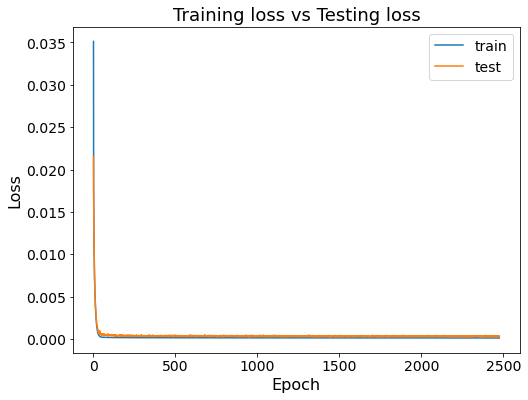

In [34]:
lr = 0.0001
EPOCHS = 8000

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)


ws_pararcnn.compile(
#               optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
              optimizer=Adam(learning_rate=lr_schedule),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/ws_pararcnn_sc1_1layer_{}h.h5'.format(K), monitor='val_mae', mode='min', verbose=2, save_best_only=True)

history = ws_pararcnn.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=True,
                       callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

In [36]:
# model_load.predict(test_input).shape

### Performance

In [35]:
from tensorflow.keras.models import load_model

saved_model = load_model('saved_model/ws_pararcnn_sc1_1layer_{}h.h5'.format(K))

In [36]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)


In [37]:
# inv_y

In [38]:
# inv_yhat

In [39]:
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 0.0559
RMSE = 0.0779
